In [3]:
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



# Load processed data

In [4]:
def load_processed_data(path: str | Path) -> pd.DataFrame:
    p = Path(path)
    if p.suffix.lower() == '.jsonl':
        with p.open('r', encoding='utf-8') as f:
            rows = [json.loads(line) for line in f if line.strip()]
        return pd.DataFrame(rows)
    else:
        return pd.read_json(p, orient='records')

# Dataset summary

In [5]:
def dataset_summary(df: pd.DataFrame) -> pd.DataFrame:
    # Hashable columns for unique count
    hashable_cols = [c for c in df.columns if df[c].apply(lambda x: not isinstance(x, list)).all()]
    
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'missing': df.isna().sum(),
        'missing_pct': df.isna().sum() / len(df) * 100,
        'non_missing': df.notna().sum(),
        'unique': df[hashable_cols].nunique(dropna=True),
    })
    
    print(f"Dataset overview: {len(df)} rows, {len(df.columns)} columns")
    
    # list-type column stats
    list_cols = [c for c in df.columns if c not in hashable_cols]
    for c in list_cols:
        summary.loc[c, 'dtype'] = str(df[c].dtype)
        summary.loc[c, 'missing'] = df[c].isna().sum()
        summary.loc[c, 'missing_pct'] = df[c].isna().sum() / len(df) * 100
        summary.loc[c, 'non_missing'] = df[c].notna().sum()
        summary.loc[c, 'unique'] = df[c].apply(lambda x: len(x) if isinstance(x, list) else 0).mean()
    
    return summary

# Text statistics

In [6]:
def _ensure_tokens_series(df: pd.DataFrame, field: str) -> pd.Series:
    col = df[field]
    return col.apply(lambda x: x if isinstance(x, list) else [])


def text_stats(df: pd.DataFrame, field: str) -> Dict[str, Any]:
    tokens_s = _ensure_tokens_series(df, field)
    lengths = tokens_s.apply(len)
    vocab = set(t for toks in tokens_s for t in toks)
    return {
        'avg_tokens_per_doc': float(lengths.mean()) if len(lengths) else 0.0,
        'median_tokens_per_doc': float(lengths.median()) if len(lengths) else 0.0,
        'vocab_size': int(len(vocab)),
    }

def sentence_stats(df: pd.DataFrame, field: str) -> dict:
    sents_series = df[field].dropna().apply(sent_tokenize)
    sent_lengths = [len(sent.split()) for doc in sents_series for sent in doc]
    return {
        'avg_words_per_sentence': float(np.mean(sent_lengths)) if sent_lengths else 0,
        'median_words_per_sentence': float(np.median(sent_lengths)) if sent_lengths else 0
    }

def most_common_tokens(df: pd.DataFrame, field: str, top_n: int = 20) -> pd.DataFrame:
    from collections import Counter
    tokens_s = _ensure_tokens_series(df, field)
    counter = Counter(t for toks in tokens_s for t in toks)
    common = counter.most_common(top_n)
    return pd.DataFrame(common, columns=['token', 'freq'])

def compare_token_stats(df: pd.DataFrame, token_fields: list) -> pd.DataFrame:
    rows = []
    for f in token_fields:
        stats = text_stats(df, f)
        rows.append({
            'field': f,
            'avg_tokens_per_doc': stats['avg_tokens_per_doc'],
            'median_tokens_per_doc': stats['median_tokens_per_doc'],
            'vocab_size': stats['vocab_size']
        })
    return pd.DataFrame(rows)

# Numeric analysis

In [8]:
def numeric_summary(df: pd.DataFrame, field: str) -> Dict[str, float]:
    s = pd.to_numeric(df[field], errors='coerce').dropna()
    if s.empty:
        return {'min': np.nan, 'max': np.nan, 'mean': np.nan, 'median': np.nan, 'std': np.nan}
    return {
        'min': float(s.min()),
        'max': float(s.max()),
        'mean': float(s.mean()),
        'median': float(s.median()),
        'std': float(s.std(ddof=1)) if len(s) > 1 else 0.0,
    }


def plot_numeric_hist(df: pd.DataFrame, field: str, bins: int = 30, title: Optional[str] = None, log_scale: bool = False) -> None:
    s = pd.to_numeric(df[field], errors='coerce')
    plt.figure(figsize=(6, 4))
    sns.histplot(s, bins=bins, kde=True, color='skyblue', edgecolor='black')
    plt.title(title or f'Histogram of {field}')
    plt.xlabel(field)
    plt.ylabel('Count')
    if log_scale:
        plt.yscale('log')
    plt.tight_layout()
    plt.show()


def plot_price_vs_rating(df: pd.DataFrame, price_col: str = 'price', rating_col: str = 'rating', log_price: bool = False) -> None:
    x = pd.to_numeric(df[price_col], errors='coerce')
    y = pd.to_numeric(df[rating_col], errors='coerce')
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.4, color='green', edgecolor=None)
    plt.xlabel(price_col)
    plt.ylabel(rating_col)
    plt.title('Price vs Rating')
    if log_price:
        plt.xscale('log')
    plt.tight_layout()
    plt.show()

def compute_numeric_correlation(df: pd.DataFrame, numeric_fields: list) -> pd.DataFrame:
    df_num = df[numeric_fields].apply(pd.to_numeric, errors='coerce')
    corr_matrix = df_num.corr()
    
    # Create a beautiful heatmap
    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    plt.title('Numeric Fields Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def top_products(df: pd.DataFrame, field: str, top_n: int = 10) -> pd.DataFrame:
    s = pd.to_numeric(df[field], errors='coerce')
    return df.assign(_val=s).sort_values('_val', ascending=False).head(top_n)


# Categorical / Stock Analysis

In [9]:
def categorical_summary(df: pd.DataFrame, field: str) -> pd.DataFrame:
    s = df[field].astype('string')
    # Filter out null, NaN, and empty string values
    s_filtered = s[(s != 'nan') & (s != 'None') & (s.notna()) & (s != '') & (s != 'null')]
    counts = s_filtered.value_counts(dropna=True)
    perc = (counts / counts.sum() * 100).round(2)
    return pd.DataFrame({'count': counts, 'percent': perc})


def plot_categorical_bar(df: pd.DataFrame, field: str, top_n: int = 20, title: Optional[str] = None) -> None:
    s = df[field].astype('string')
    # Filter out null, NaN, and empty string values
    s_filtered = s[(s != 'nan') & (s != 'None') & (s.notna()) & (s != '') & (s != 'null')]
    counts = s_filtered.value_counts().head(top_n)
    perc = (counts / counts.sum() * 100).round(1)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
    plt.title(title or f'Top {top_n} {field}')
    plt.xlabel('Count')
    plt.ylabel(field)

    # Annotate bars with count and percentage
    for i, v in enumerate(counts.values):
        plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')

        
    plt.tight_layout()
    plt.show()


def plot_categorical_pie(df: pd.DataFrame, field: str, top_n: int = 10, title: Optional[str] = None) -> None:
    if plt is None:
        print('Matplotlib not available.')
        return
    s = df[field].astype('string')
    # Filter out null, NaN, and empty string values
    s_filtered = s[(s != 'nan') & (s != 'None') & (s.notna()) & (s != '') & (s != 'null')]
    counts = s_filtered.value_counts().head(top_n)
    # Slightly separate the first (largest) slice to emphasize it
    explode = [0.05] + [0] * (len(counts) - 1)
    plt.figure(figsize=(6, 6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140, explode=explode)
    plt.title(title or f'{field} distribution (Top {top_n})')
    plt.tight_layout()
    plt.show()


# Word Clouds

In [10]:
def generate_wordcloud(tokens_list: List[List[str]], title: str = 'Word Cloud') -> None:
    text = ' '.join(' '.join(toks) for toks in tokens_list)
    if not text.strip():
        print(f"Word cloud skipped for '{title}' (no tokens).")
        return
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Markdown Summary

In [11]:
def render_markdown_summary(top_brands: pd.DataFrame,
                            top_categories: pd.DataFrame,
                            price_stats: Dict[str, float],
                            rating_stats: Dict[str, float],
                            discount_stats: Dict[str, float],
                            out_of_stock_ratio: float,
                            token_info: Dict[str, Any],
                            top_sellers: pd.DataFrame = None) -> str:
    md = []
    md.append('## EDA Summary')
    md.append(f"- Rows analyzed: {int(top_brands['count'].sum())}")
    md.append(f"- Top brands: {', '.join(top_brands.head(5).index.astype(str))}")
    md.append(f"- Top categories: {', '.join(top_categories.head(5).index.astype(str))}")
    if top_sellers is not None:
        md.append(f"- Top sellers: {', '.join(top_sellers.head(5).index.astype(str))}")
    md.append(f"- Price: min {price_stats.get('min', 0):.2f}, median {price_stats.get('median', 0):.2f}, mean {price_stats.get('mean', 0):.2f}, max {price_stats.get('max', 0):.2f}")
    md.append(f"- Discount: min {discount_stats.get('min', 0):.2f}, median {discount_stats.get('median', 0):.2f}, mean {discount_stats.get('mean', 0):.2f}, max {discount_stats.get('max', 0):.2f}")
    md.append(f"- Rating: mean {rating_stats.get('mean', 0):.2f}, median {rating_stats.get('median', 0):.2f}")
    md.append(f"- Out-of-stock ratio: {out_of_stock_ratio:.2%}")
    md.append(f"- Tokens: avg/doc {token_info.get('avg_tokens_per_doc',0):.1f}, median/doc {token_info.get('median_tokens_per_doc',0):.1f}, vocab {token_info.get('vocab_size',0)}")
    return '\n'.join(md)

# Run EDA

Data loaded: 28080 rows, 25 columns

Dataset overview: 28080 rows, 25 columns


,dtype,missing,missing_pct,non_missing,unique
_id,object,0,0.000000,28080,28080.000000
actual_price,float64,777,2.767094,27303,727.000000
average_rating,float64,2261,8.051994,25819,38.000000
brand,object,0,0.000000,28080,322.000000
brand_tokens,object,0,0.000000,28080,1.108155
category,object,0,0.000000,28080,4.000000
category_tokens,object,0,0.000000,28080,1.968661
crawled_at,datetime64[ns],0,0.000000,28080,16641.000000
description,object,0,0.000000,28080,5474.000000
description_tokens,object,0,0.000000,28080,19.713105



--- Text Statistics ---
title_tokens: avg tokens/doc=6.1, median=6.0, vocab_size=609
description_tokens: avg tokens/doc=19.7, median=10.0, vocab_size=4806
details_tokens: avg tokens/doc=40.1, median=40.0, vocab_size=5584
category_tokens: avg tokens/doc=2.0, median=2.0, vocab_size=7
subcategory_tokens: avg tokens/doc=1.4, median=1.0, vocab_size=39
brand_tokens: avg tokens/doc=1.1, median=1.0, vocab_size=355
tokens: avg tokens/doc=70.3, median=62.0, vocab_size=8670
title: avg words/sentence=6.7, median=7.0
description: avg words/sentence=50.3, median=40.0


,field,avg_tokens_per_doc,median_tokens_per_doc,vocab_size
0,title_tokens,6.051638,6.0,609
1,description_tokens,19.713105,10.0,4806
2,details_tokens,40.101816,40.0,5584
3,category_tokens,1.968661,2.0,7
4,subcategory_tokens,1.391702,1.0,39
5,brand_tokens,1.108155,1.0,355
6,tokens,70.335078,62.0,8670



Top tokens in title_tokens:


,token,freq
0,shirt,15838
1,women,13146
2,men,13060
3,neck,11952
4,solid,9246
5,round,8301
6,print,8123
7,pack,4839
8,blue,4378
9,fit,3923



Top tokens in description_tokens:


,token,freq
0,shirt,18730
1,cotton,10139
2,wear,9375
3,comfort,8848
4,look,6413
5,casual,6034
6,fit,5832
7,made,5643
8,fabric,5516
9,print,4888



Top tokens in details_tokens:


,token,freq
0,fabric,51299
1,sleev,45174
2,neck,42499
3,type,38283
4,color,33748
5,fit,30010
6,style,26293
7,pattern,26191
8,code,25763
9,regular,24126



Top tokens in category_tokens:


,token,freq
0,cloth,27118
1,accessori,27118
2,footwear,920
3,bag,41
4,wallet,41
5,belt,41
6,toy,1



Top tokens in subcategory_tokens:


,token,freq
0,topwear,15310
1,bottomwear,3666
2,winter,2493
3,wear,2493
4,cloth,1824
5,accessori,1824
6,innerwear,1762
7,swimwear,1762
8,kurta,1180
9,ethnic,1180



Top tokens in brand_tokens:


,token,freq
0,ecko,951
1,unl,951
2,free,860
3,authori,860
4,arbo,806
5,reeb,802
6,true,793
7,keo,660
8,black,630
9,amp,585



Top tokens in tokens:


,token,freq
0,fabric,57885
1,neck,57442
2,sleev,51425
3,shirt,51376
4,fit,39765
5,type,38734
6,color,37509
7,cotton,34482
8,wear,31720
9,cloth,31231



Word cloud for title_tokens


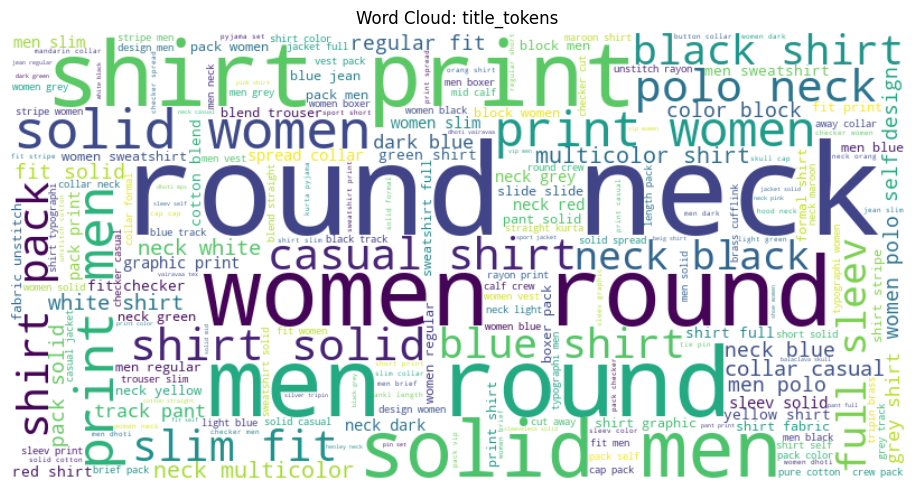


Word cloud for description_tokens


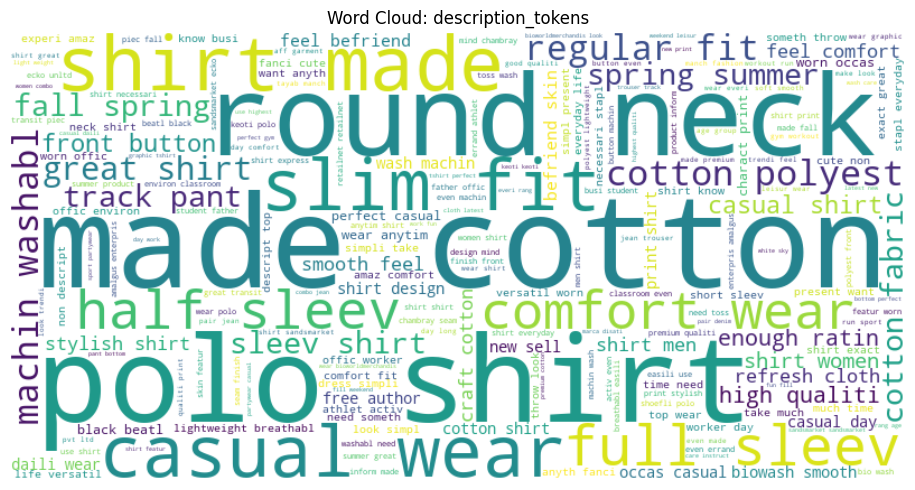


Word cloud for details_tokens


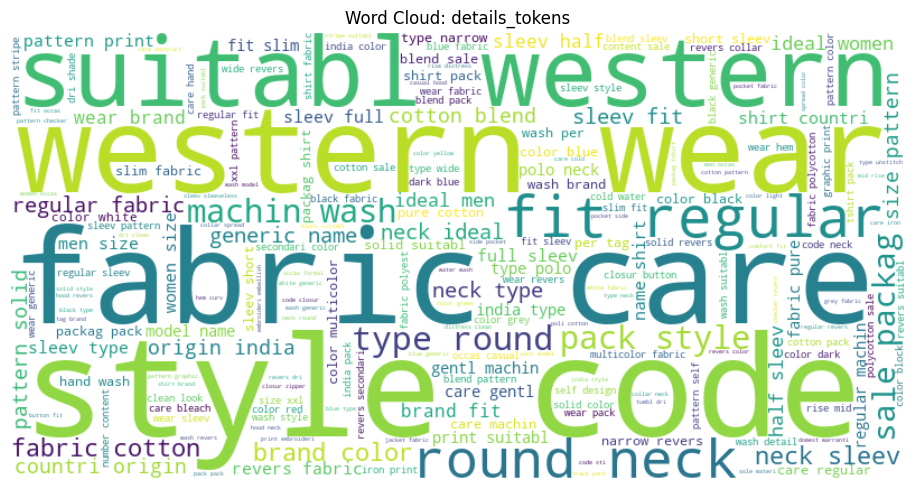


Word cloud for category_tokens


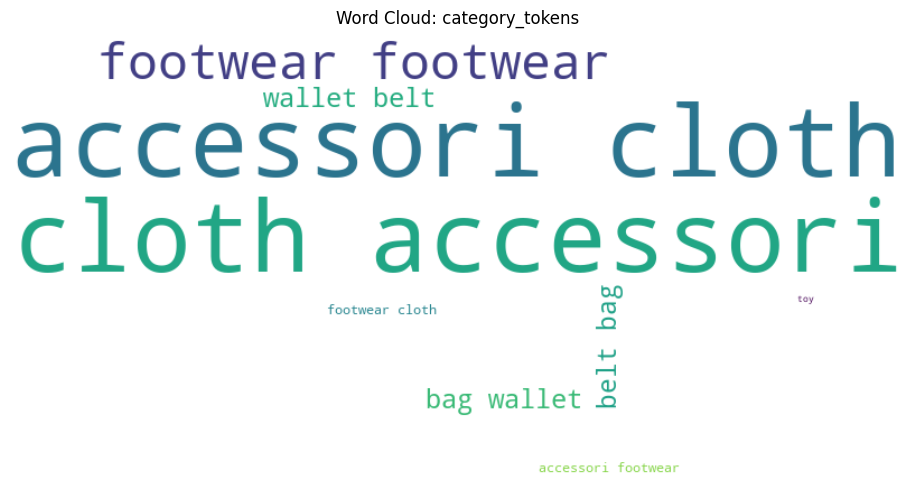


Word cloud for subcategory_tokens


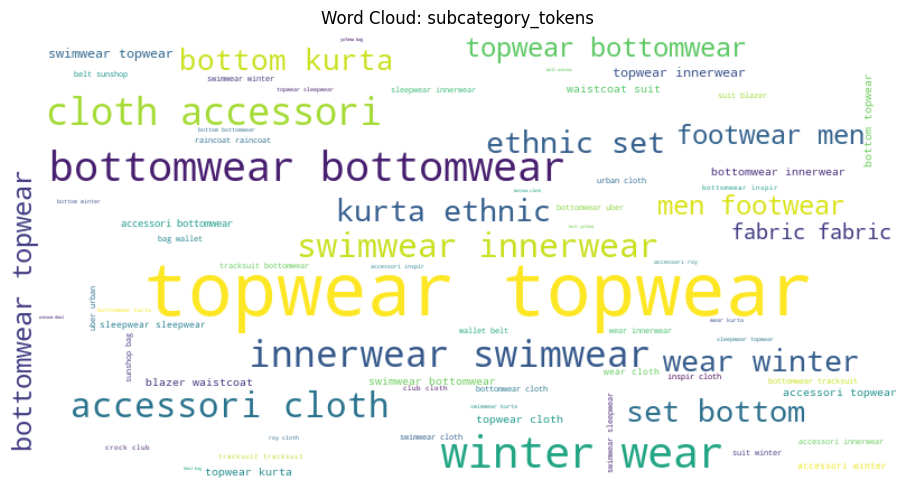


Word cloud for brand_tokens


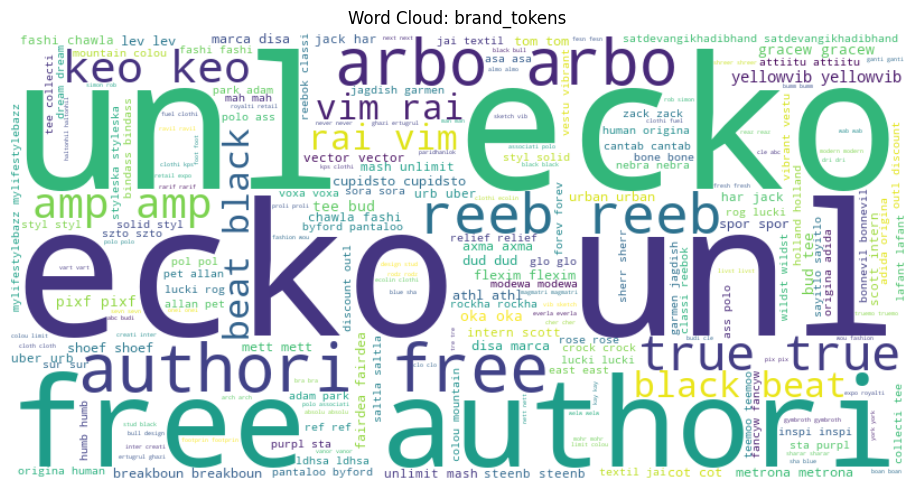


Word cloud for tokens


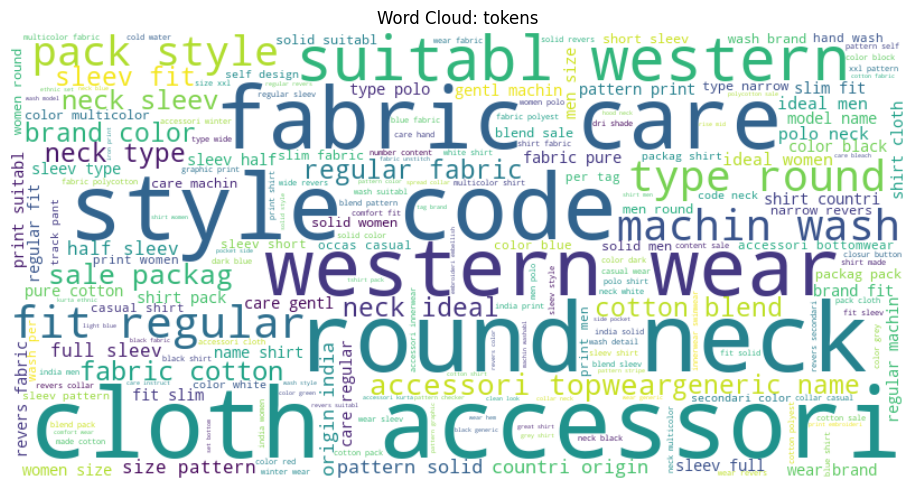

selling_price: {'min': 99.0, 'max': 7999.0, 'mean': 705.6350879692286, 'median': 545.0, 'std': 549.6814891102233}
actual_price: {'min': 150.0, 'max': 12999.0, 'mean': 1455.5281104640517, 'median': 1199.0, 'std': 939.9774558309044}
discount: {'min': 1.0, 'max': 87.0, 'mean': 50.25689623507805, 'median': 53.0, 'std': 16.887287396142305}
average_rating: {'min': 1.0, 'max': 5.0, 'mean': 3.6277237693171687, 'median': 3.8, 'std': 0.6634293345254286}


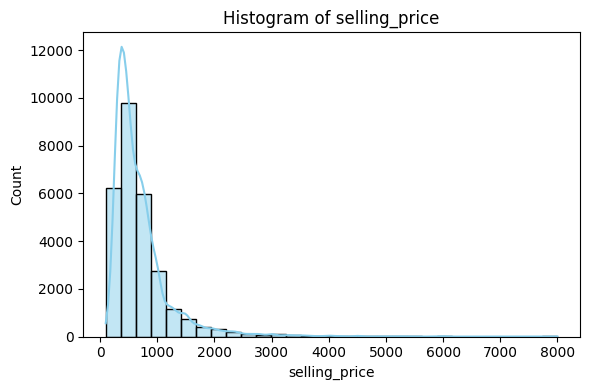

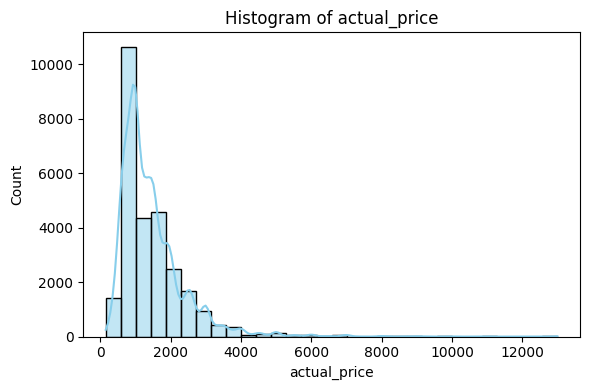

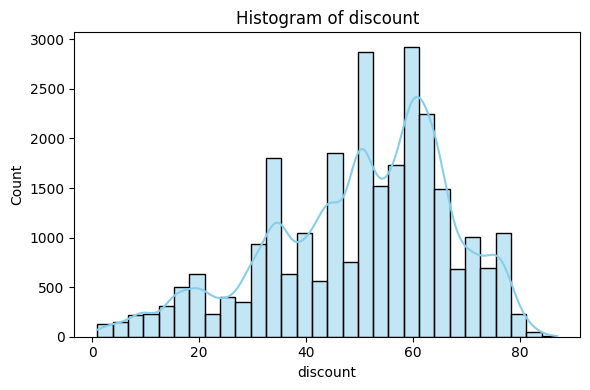

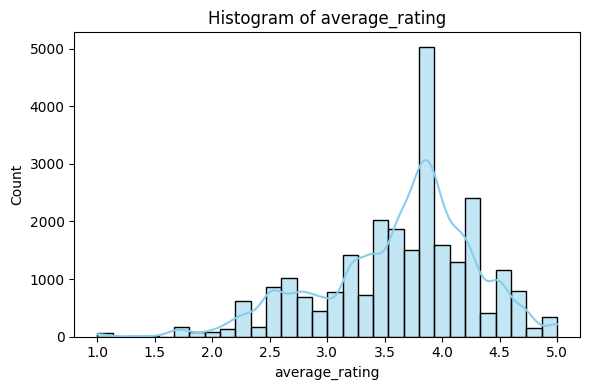

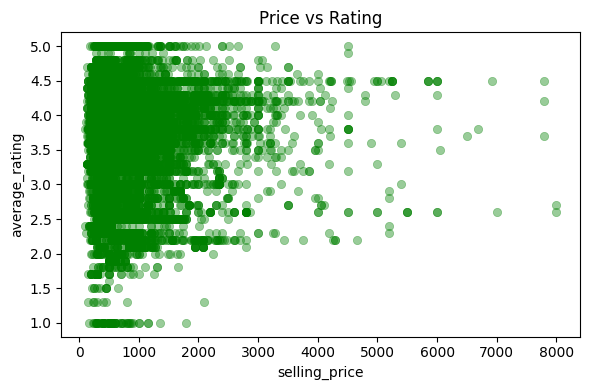

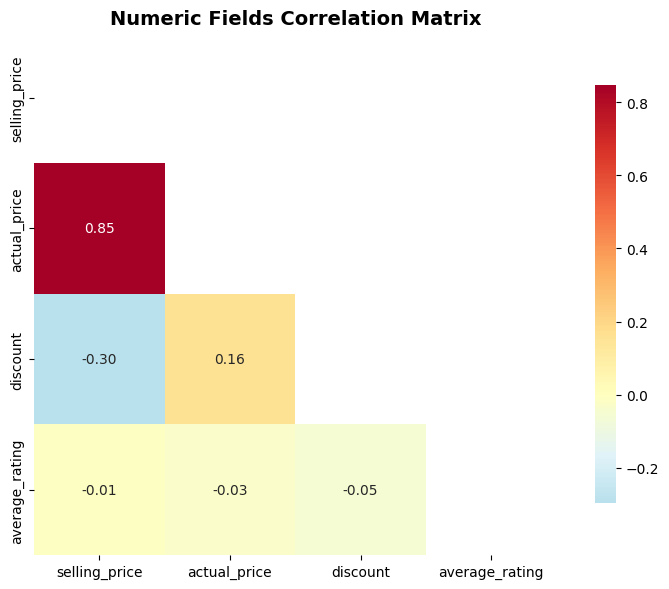


Numeric correlation matrix:


,selling_price,actual_price,discount,average_rating
selling_price,1.000000,0.847782,-0.295486,-0.007639
actual_price,0.847782,1.000000,0.156480,-0.031853
discount,-0.295486,0.156480,1.000000,-0.051480
average_rating,-0.007639,-0.031853,-0.051480,1.000000



Top 5 products by price:


,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,...,url,title_tokens,brand_tokens,category_tokens,subcategory_tokens,details_tokens,description_tokens,tokens,full_text,_val
2067,b0723b53-654d-5b22-b98a-0565bb0a2f2d,9999.0,2.7,reeb,clothing and accessories,2021-02-10 20:33:58,cbt cmg track suit,20.0,[https://rukminim1.flixcart.com/image/128/128/...,True,...,https://www.flipkart.com/reebok-solid-men-trac...,"[solid, women, track, suit]",[reeb],"[cloth, accessori]",[tracksuit],"[color, black, pattern, solid, style, code, se...","[cbt, cmg, track, suit]","[solid, women, track, suit, cbt, cmg, track, s...",solid women track suit cbt cmg track suit clot...,7999.0
11010,c3b0cf3b-6b71-5c69-8086-82ef76361c4a,7999.0,2.6,true bl,clothing and accessories,2021-02-10 22:22:13,,NaN,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/true-blue-checkered-s...,"[checker, singl, breast, parti, women, full, s...",[true],"[cloth, accessori]","[blazer, waistcoat, suit]","[color, grey, fabric, polyest, pattern, checke...",[arvindtrueblu],"[checker, singl, breast, parti, women, full, s...",checkered single breasted party women full sle...,7998.0
26089,47d09c94-3e3c-55b8-9611-906ce9bf7e3a,12999.0,4.5,pu,clothing and accessories,2021-02-11 01:12:12,,40.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/puma-full-sleeve-prin...,"[full, sleev, print, men, sweatshirt]",[],"[cloth, accessori]","[winter, wear]","[color, black, fabric, polyest, pattern, print...",[retailnet],"[full, sleev, print, men, sweatshirt, cloth, a...",full sleeve printed men sweatshirt clothing a...,7799.0
25815,a0b220a6-da00-5e0a-a64e-ef78921d8e5d,12999.0,3.7,pu,clothing and accessories,2021-02-11 01:09:12,stylish and trendy jacket for women,40.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/puma-full-sleeve-soli...,"[full, sleev, solid, women, casual, jacket]",[],"[cloth, accessori]","[winter, wear]","[color, black, fabric, cotton, blend, pattern,...","[stylish, trendi, jacket, women, retailnet]","[full, sleev, solid, women, casual, jacket, st...",full sleeve solid women casual jacket stylish ...,7799.0
6895,3856ec4c-65d3-555f-9666-8a27ddc2f41d,12990.0,4.2,g,clothing and accessories,2021-02-10 21:30:13,sax zip,40.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/gas-skinny-men-blue-j...,"[skinni, men, blue, jean]",[],"[cloth, accessori]",[bottomwear],"[style, code, ideal, men, suitabl, western, we...","[sax, zip, retailnet]","[skinni, men, blue, jean, sax, zip, cloth, acc...",skinny men blue jeans sax zip clothing and acc...,7794.0



Top 5 products by rating:


,_id,actual_price,average_rating,brand,category,crawled_at,description,discount,images,out_of_stock,...,url,title_tokens,brand_tokens,category_tokens,subcategory_tokens,details_tokens,description_tokens,tokens,full_text,_val
22361,9c3f3588-5d9d-52fc-9ae9-e8bb40e325ba,770.0,5.0,col,clothing and accessories,2021-02-11 00:30:53,regular use fit,50.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/colin-men-brief/p/itm...,"[men, brief, pack]",[col],"[cloth, accessori]","[innerwear, swimwear]","[color, multicolor, fabric, cotton, jersey, pa...","[regular, use, fit, skipperind]","[men, brief, pack, regular, use, fit, cloth, a...",men brief pack of regular use fit clothing and...,5.0
8403,9c713a25-7c46-52d6-b021-f0baa08c7b51,1196.0,5.0,,clothing and accessories,2021-02-10 21:49:22,all day comfort and support from work to play ...,7.0,[https://rukminim1.flixcart.com/image/128/128/...,True,...,https://www.flipkart.com/vip-men-vest/p/itm224...,"[vip, women, vest, pack]",[],"[cloth, accessori]","[innerwear, swimwear]","[neck, round, neck, pattern, solid, sleev, hal...","[day, comfort, support, work, play, possibl, i...","[vip, women, vest, pack, day, comfort, support...",vip women vest pack of all day comfort and sup...,5.0
14764,b5470adc-a795-533a-a89f-523fff5357e5,899.0,5.0,tee bud,clothing and accessories,2021-02-10 23:08:41,,61.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/tee-buddy-graphic-pri...,"[graphic, print, women, round, neck, white, sh...","[tee, bud]","[cloth, accessori]",[topwear],"[type, round, neck, sleev, short, sleev, fit, ...","[shirt, express]","[graphic, print, women, round, neck, white, sh...",graphic print women round neck white t shirt ...,5.0
13240,b137c8dc-203c-5e1f-9138-12a4f39aa637,NaN,5.0,viking ine,clothing and accessories,2021-02-10 22:50:02,cm,NaN,[https://rukminim1.flixcart.com/image/128/128/...,True,...,https://www.flipkart.com/viking-iners-men-brie...,"[men, brief, pack]","[vike, ine]","[cloth, accessori]","[innerwear, swimwear]","[color, multicolor, fabric, cotton, blend, sty...",[],"[men, brief, pack, cloth, accessori, innerwear...",men brief pack of cm clothing and accessories ...,5.0
10472,1b793ed6-29f2-5a65-9dbf-67490961cb66,2799.0,5.0,true bl,clothing and accessories,2021-02-10 22:14:03,,60.0,[https://rukminim1.flixcart.com/image/128/128/...,False,...,https://www.flipkart.com/true-blue-men-printed...,"[men, slim, fit, print, spread, collar, casual...",[true],"[cloth, accessori]",[topwear],"[pack, style, code, beig, fit, slim, fabric, c...",[kapsonsretailpvtltd],"[men, slim, fit, print, spread, collar, casual...",men slim fit printed spread collar casual shir...,5.0



Categorical summary: brand


,count,percent
brand,,
ecko unl,951,3.65
free authori,860,3.3
arbo,806,3.09
reeb,802,3.08
pu,798,3.06
...,...,...
transperan,1,0.0
krv,1,0.0
k j trade,1,0.0


C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')


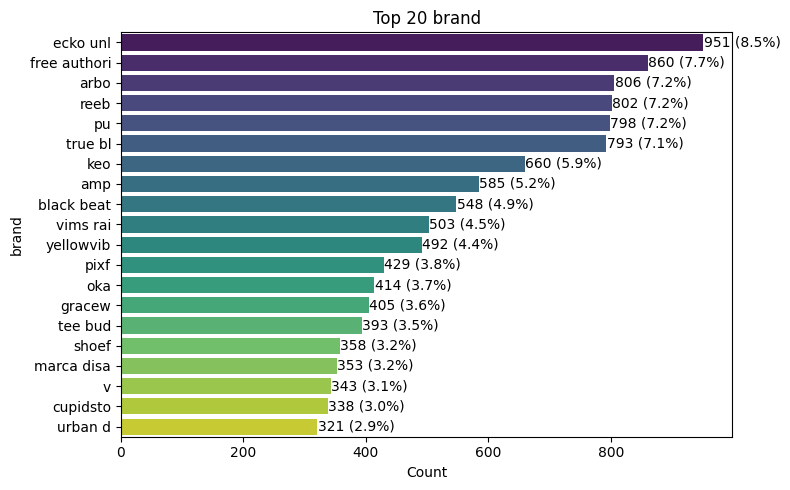

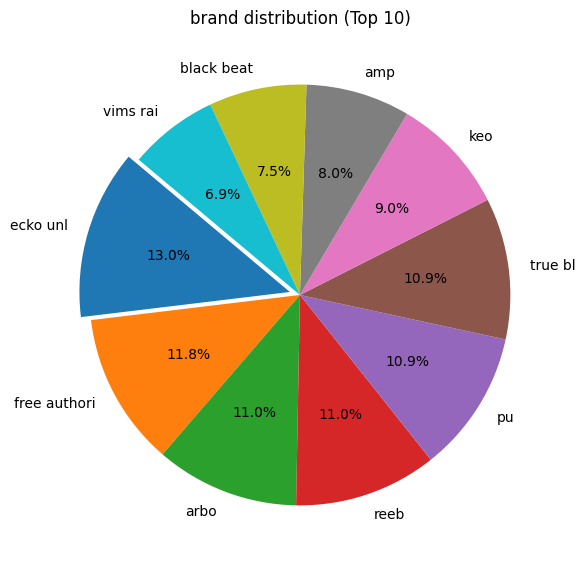


Categorical summary: seller


,count,percent
seller,,
retailnet,1411,5.34
sandsmarketing,887,3.36
bioworldmerchandising,842,3.19
arbor,783,2.96
keoti,660,2.5
...,...,...
flipkat fashion,1,0.0
studio arus,1,0.0
design for desire,1,0.0


C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')


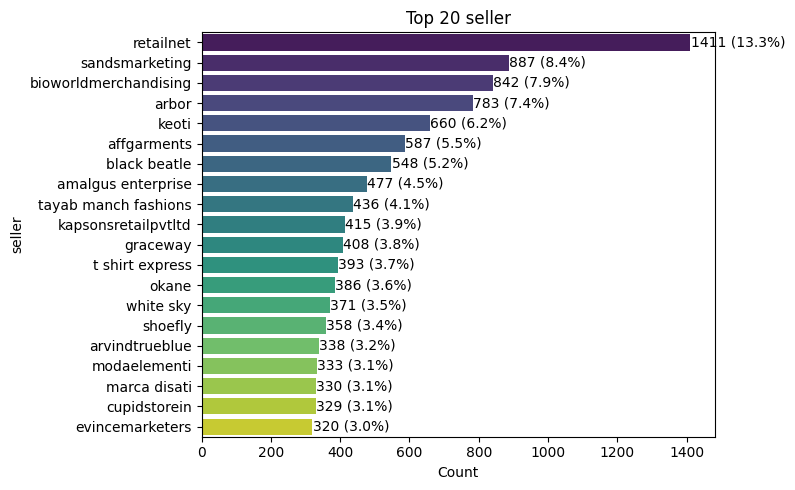

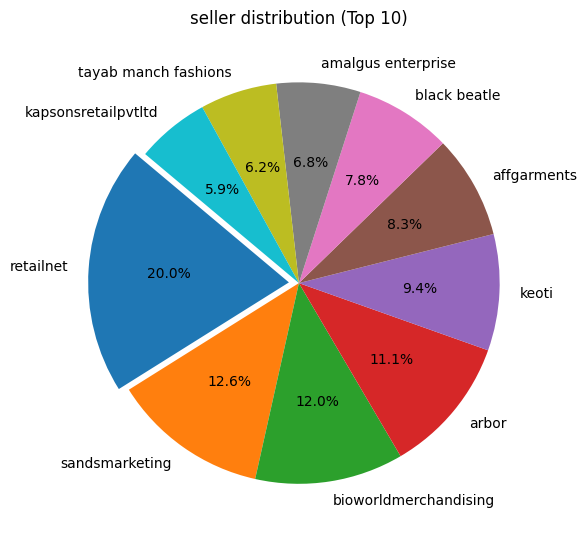


Categorical summary: category


,count,percent
category,,
clothing and accessories,27118,96.57
footwear,920,3.28
bags wallets belts,41,0.15
toys,1,0.0


C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')


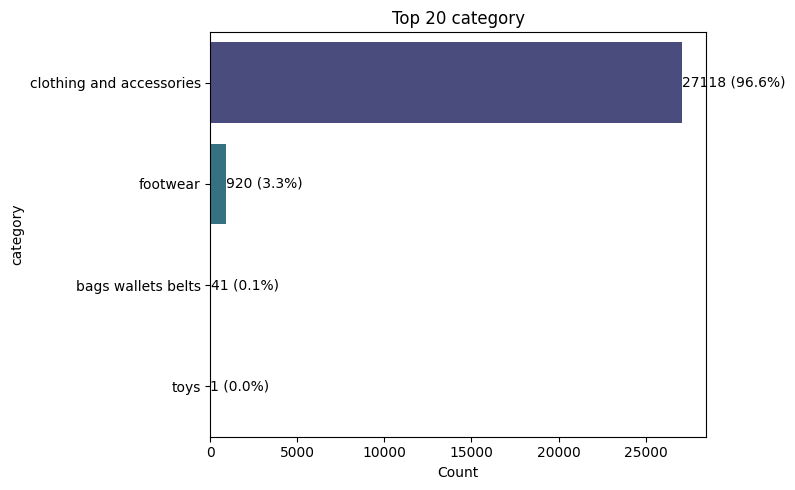

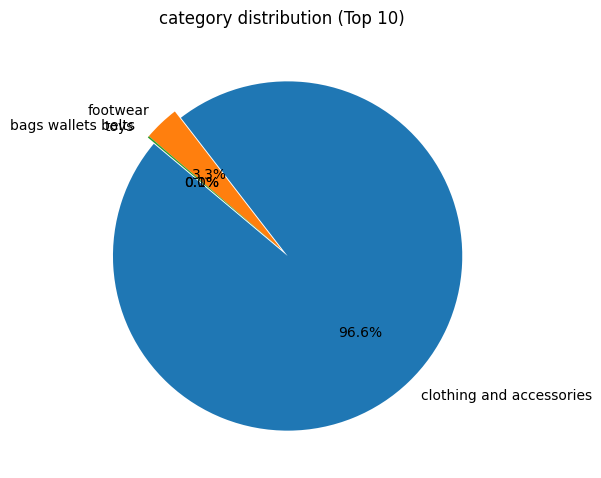


Categorical summary: sub_category


,count,percent
sub_category,,
topwear,15310,54.52
bottomwear,3666,13.06
winter wear,2493,8.88
innerwear and swimwear,1762,6.27
clothing accessories,1742,6.2
kurtas ethnic sets and bottoms,1180,4.2
men s footwear,920,3.28
fabrics,534,1.9
sleepwear,122,0.43


C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')


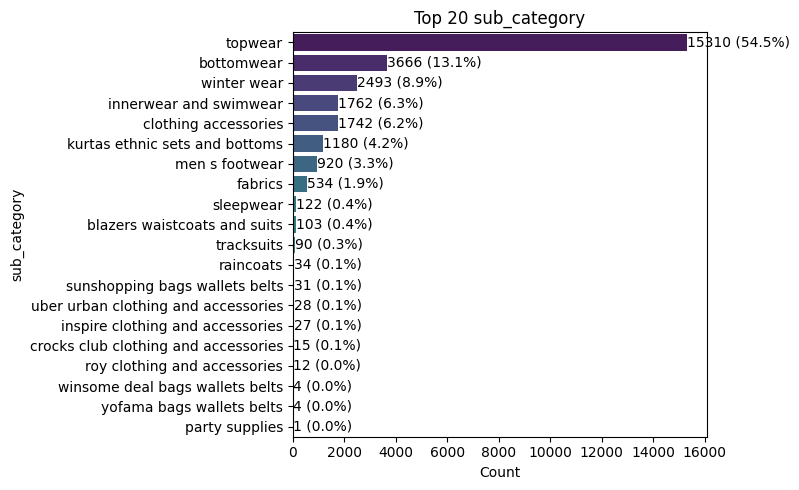

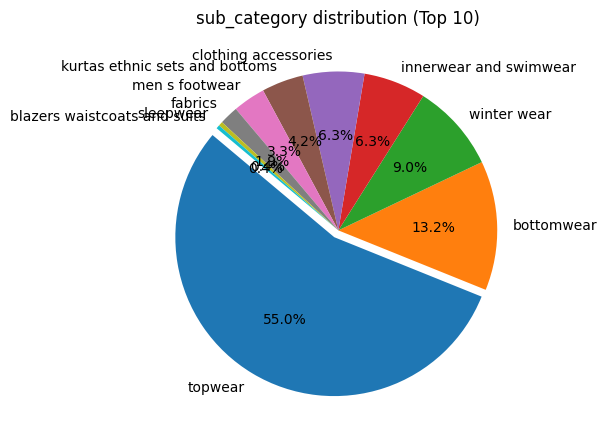


Categorical summary: out_of_stock


,count,percent
out_of_stock,,
False,26436,94.15
True,1644,5.85


C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, order=counts.index, palette='viridis')
C:\Users\janag\AppData\Local\Temp\ipykernel_15924\2975981294.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(v + 0.5, i, f"{v} ({perc[i]}%)", va='center')


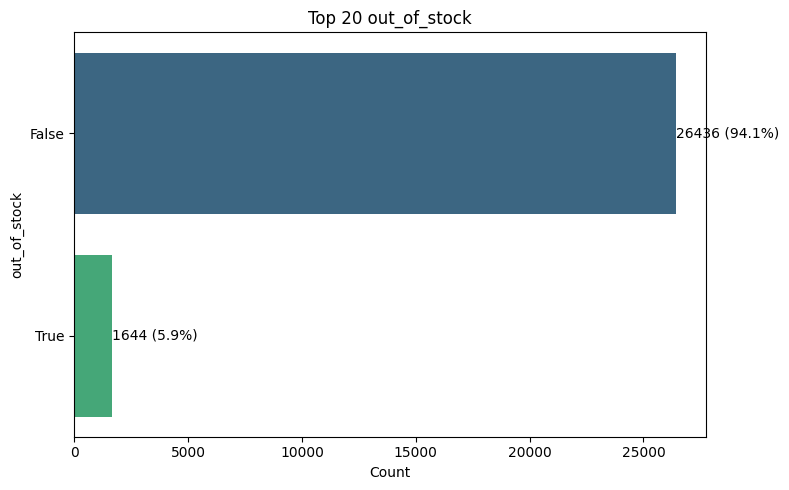

## EDA Summary
- Rows analyzed: 26071
- Top brands: ecko unl, free authori, arbo, reeb, pu
- Top categories: clothing and accessories, footwear, bags wallets belts, toys
- Top sellers: retailnet, sandsmarketing, bioworldmerchandising, arbor, keoti
- Price: min 99.00, median 545.00, mean 705.64, max 7999.00
- Discount: min 1.00, median 53.00, mean 50.26, max 87.00
- Rating: mean 3.63, median 3.80
- Out-of-stock ratio: 5.85%
- Tokens: avg/doc 70.3, median/doc 62.0, vocab 8670

In [12]:
# Load processed data 
df = load_processed_data("data/processed_corpus.json")
print(f"Data loaded: {len(df)} rows, {len(df.columns)} columns\n")

# Dataset summary
summary_df = dataset_summary(df)
display(summary_df)

# Text statistics
token_fields = ['title_tokens', 'description_tokens', 'details_tokens', 'category_tokens', 'subcategory_tokens', 'brand_tokens', 'tokens']

print("\n--- Text Statistics ---")
for field in token_fields:
    stats = text_stats(df, field)
    print(f"{field}: avg tokens/doc={stats['avg_tokens_per_doc']:.1f}, median={stats['median_tokens_per_doc']:.1f}, vocab_size={stats['vocab_size']}")

# Sentence stats
for field in ['title', 'description']:
    sent_stats = sentence_stats(df, field)
    print(f"{field}: avg words/sentence={sent_stats['avg_words_per_sentence']:.1f}, median={sent_stats['median_words_per_sentence']:.1f}")

# Compare token stats across fields
token_comparison_df = compare_token_stats(df, token_fields)
display(token_comparison_df)

# Most common tokens per field
for field in token_fields:
    print(f"\nTop tokens in {field}:")
    display(most_common_tokens(df, field, top_n=10))

# Word clouds
for field in token_fields:
    print(f"\nWord cloud for {field}")
    generate_wordcloud(_ensure_tokens_series(df, field).tolist(), title=f"Word Cloud: {field}")

# Numeric analysis
numeric_fields = ['selling_price', 'actual_price', 'discount', 'average_rating']
for field in numeric_fields:
    stats = numeric_summary(df, field)
    print(f"{field}: {stats}")

# Histograms and scatterplots
for field in numeric_fields:
    plot_numeric_hist(df, field, bins=30)

plot_price_vs_rating(df, price_col='selling_price', rating_col='average_rating')

# Correlation matrix
corr_df = compute_numeric_correlation(df, numeric_fields)
print("\nNumeric correlation matrix:")
display(corr_df)

# Top products by price and rating
print("\nTop 5 products by price:")
display(top_products(df, 'selling_price', top_n=5))
print("\nTop 5 products by rating:")
display(top_products(df, 'average_rating', top_n=5))

# Categorical / stock analysis
categorical_fields = ['brand', 'seller', 'category', 'sub_category', 'out_of_stock']
for field in categorical_fields:
    print(f"\nCategorical summary: {field}")
    display(categorical_summary(df, field))
    plot_categorical_bar(df, field)
    if field != 'out_of_stock':
        plot_categorical_pie(df, field)

# Markdown summary
top_brands = categorical_summary(df, 'brand')
top_categories = categorical_summary(df, 'category')
top_sellers = categorical_summary(df, 'seller')

price_stats = numeric_summary(df, 'selling_price')
rating_stats = numeric_summary(df, 'average_rating')
discount_stats = numeric_summary(df, 'discount')
out_of_stock_ratio = df['out_of_stock'].mean()

# Use tokens for token info
token_info = text_stats(df, 'tokens')

md_summary = render_markdown_summary(
    top_brands=top_brands,
    top_categories=top_categories,
    price_stats=price_stats,
    rating_stats=rating_stats,
    discount_stats=discount_stats,
    out_of_stock_ratio=out_of_stock_ratio,
    token_info=token_info,
    top_sellers=top_sellers
)

from IPython.display import Markdown
display(Markdown(md_summary))